<a href="https://colab.research.google.com/github/CheshireCat12/Deep_learning_challenges/blob/master/CAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from torch.autograd import Variable
from torch.utils.data import DataLoader

In [0]:
DOWNLOAD_DATASET = True
BATCH_SIZE = 64
NB_TEST_IMG = 5
NB_EPOCHS = 10
DEVICE= torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [0]:
norm_mean = [0.1307]
norm_std = [0.3081]

pre_process = transforms.Compose([transforms.ToTensor(),
                                  transforms.Normalize(
                                    mean=norm_mean,
                                    std=norm_std)])

train_data = datasets.MNIST(root='./data',
                            train=True,
                            transform=pre_process,
                            download=True)
 
train_loader = DataLoader(train_data,
                          batch_size=BATCH_SIZE,
                          shuffle=True)

In [0]:
class ConvolutionAutoEncoder(nn.Module):
    
    def __init__(self):
        super(ConvolutionAutoEncoder, self).__init__()
        
        # self.encoder = nn.Sequential(
        #     nn.Conv2d(1, 16, kernel_size=3, padding=1), # 16, 28, 28
        #     nn.ReLU(),
        #     nn.MaxPool2d(2), # 16, 14, 14
        #     nn.Conv2d(16, 8, kernel_size=3, padding=1), # 8, 14, 14
        #     nn.ReLU(),
        #     nn.MaxPool2d(2), # 8, 7, 7
        #     nn.Conv2d(8, 8, kernel_size=3, padding=1), # 8, 7, 7
        #     nn.ReLU(),
        #     nn.MaxPool2d(2, stride=1) # 8, 6, 6
        # )
        # 
        # self.decoder = nn.Sequential(
        #     nn.ConvTranspose2d(8, 16, kernel_size=3, stride=1), # 16, 8, 8
        #     nn.ReLU(),
        #     nn.ConvTranspose2d(16, 8, kernel_size=5, stride=2, padding=1), # 16, 17, 17
        #     nn.ReLU(),
        #     nn.ConvTranspose2d(8, 1, kernel_size=2, stride=2, padding=3), # 1, 28, 28
        #     nn.Tanh()
        # )
        
        # self.encoder = nn.Sequential(
        #     nn.Conv2d(1, 16, 3, stride=3, padding=1),  # b, 16, 10, 10
        #     nn.ReLU(True),
        #     nn.MaxPool2d(2, stride=2),  # b, 16, 5, 5
        #     nn.Conv2d(16, 8, 3, stride=2, padding=1),  # b, 8, 3, 3
        #     nn.ReLU(True),
        #     nn.MaxPool2d(2, stride=1)  # b, 8, 2, 2
        # )
        # self.decoder = nn.Sequential(
        #     nn.ConvTranspose2d(8, 16, 3, stride=2),  # b, 16, 5, 5
        #     nn.ReLU(True),
        #     nn.ConvTranspose2d(16, 8, 5, stride=3, padding=1),  # b, 8, 15, 15
        #     nn.ReLU(True),
        #     nn.ConvTranspose2d(8, 1, 2, stride=2, padding=1),  # b, 1, 28, 28
        #     nn.Tanh()
        # )
        
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5),
            nn.ReLU(),
            nn.Conv2d(6, 16, kernel_size=5),
            nn.ReLU()
        )

        self.decoder = nn.Sequential(             
            nn.ConvTranspose2d(16, 6, kernel_size=5),
            nn.ReLU(),
            nn.ConvTranspose2d(6, 1, kernel_size=5),
            #nn.ReLU(),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        
        return encoded, decoded

In [49]:
CAE = ConvolutionAutoEncoder()
CAE.to(DEVICE)
print(CAE)

optimizer_cae = torch.optim.Adam(CAE.parameters(), weight_decay=1e-5)
loss_func_cae = nn.MSELoss()

view_data_cae = Variable(train_data.data[:NB_TEST_IMG].view(-1, 1, 28, 28).type(torch.cuda.FloatTensor))

ConvolutionAutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (3): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(16, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(6, 1, kernel_size=(5, 5), stride=(1, 1))
    (3): Sigmoid()
  )
)


In [0]:
def plot_img(model, view_data):
    _, decoded_data = model(view_data)  
    
    f, a = plt.subplots(2, NB_TEST_IMG, figsize=(10, 4))
    
    for i in range(NB_TEST_IMG):
        a[0][i].imshow(np.reshape(view_data.cpu().data.numpy()[i],
                                   (28, 28)),
                                   cmap='gray')
        a[0][i].set_xticks(())
        a[0][i].set_yticks(())
    
        
    for i in range(NB_TEST_IMG):
        a[1][i].imshow(np.reshape(decoded_data.cpu().data.numpy()[i],
                                   (28, 28)),
                                   cmap='gray')
        a[1][i].set_xticks(())
        a[1][i].set_yticks(())

    plt.show()
    

def trainCAE(model, data_loader, view_data, loss_func, optimizer):
    for epoch in range(NB_EPOCHS):
        for x, _ in data_loader:
            x = Variable(x).to(DEVICE)
            y = Variable(x).to(DEVICE)
            
            # ===================forward=====================
            encoded, decoded = model(x)
            loss = loss_func(decoded, y)
            # ===================backward=====================
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        print(f'Epoch: {epoch}/{NB_EPOCHS} | Loss: {loss.item():.4f}')
        
        if not epoch % 5:
            plot_img(model, view_data)

Epoch: 0/10 | Loss: 0.4425


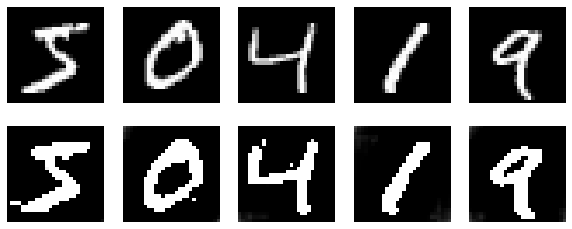

Epoch: 1/10 | Loss: 0.4526
Epoch: 2/10 | Loss: 0.5122
Epoch: 3/10 | Loss: 0.4504
Epoch: 4/10 | Loss: 0.4406
Epoch: 5/10 | Loss: 0.4607


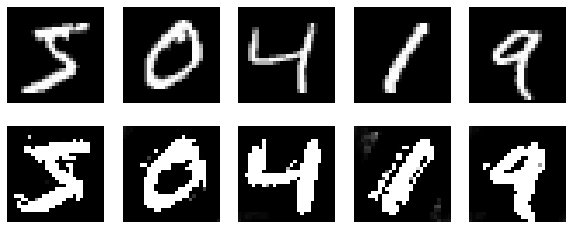

Epoch: 6/10 | Loss: 0.4463
Epoch: 7/10 | Loss: 0.4558
Epoch: 8/10 | Loss: 0.4548
Epoch: 9/10 | Loss: 0.4447


In [51]:
trainCAE(CAE, train_loader, view_data_cae, loss_func_cae, optimizer_cae)

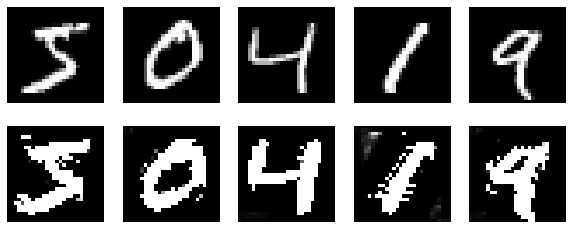

In [52]:
plot_img(CAE, view_data_cae)